<a href="https://colab.research.google.com/github/sameerkulkarni/financial_simulations/blob/master/base_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Financial Simulations

Measure different investment strategies

## Helper Functions
Run me before running any of the lower cells.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
findata = pd.read_csv("https://raw.githubusercontent.com/sameerkulkarni/financial_simulations/master/returns.csv", sep=",")
# Add data of monthly rate of change in adj close.
findata['Scale'] = findata['Adj Close'].pct_change() +1
# Adjust the scale to inflation every month.
findata['Scale_InfAdj'] = findata['Scale'] - (findata['Inflation']/1200)
findata = findata.drop(['Open', 'High', 'Low'], axis=1)
fin_index = pd.Index(findata['Date'])

# Number of times to run any of the simulations below
NUM_SAMPLES=10000

def pretty_plot_fn(distribution, heighlight_value, message):
  plt.hist(distribution, bins=100)
  plt.title(message)
  plt.axvline(heighlight_value,color='r')
  plt.show()

# The three functions below calucate the rate of returs given a start point and 
# a duration. e.g. A value of 1.07 would mean a 7% average return on investment
# annually over the investment period.

# 1. Basic Strategy: Invest once; for the entire duration.
def calculate_returns(startpoint, duration):
  begin = findata.loc[startpoint]['Adj Close']
  end = findata.loc[startpoint+(duration*12)]['Adj Close']
  total_returns = 1+ ((end-begin)/begin)
  avg_returns = (total_returns**(1.0/duration))
  return avg_returns

# 2. Secondary strategy: If the intended retirement would cause an average
#    return of less than expected_returns, then wait a max of extended_duration
#    years and retire as soon as it reaches expected_returns. If waiting does
#    not reachexpected returns, retire at the end of the extended_duration.
def flexible_end_date(startpoint, duration, extended_duration=2, expected_returns=1.065):
  begin = findata.loc[startpoint]['Adj Close']
  intended_end_month= startpoint+(duration*12)
  end = findata.loc[intended_end_month]['Adj Close']
  total_returns = 1+ ((end-begin)/begin)
  avg_returns = (total_returns**(1.0/duration))
  # print("%2d, %2d, %3.3f, %3.3f, %1.3f, %1.3f" %(startpoint, intended_end_month, begin, end, total_returns, avg_returns))
  if (avg_returns > expected_returns):
    return avg_returns
  for i in range(intended_end_month,intended_end_month+(extended_duration*12)):
    end = findata.loc[i]['Adj Close']
    total_returns= 1+ ((end-begin)/begin)
    avg_returns = (total_returns**(1.0/((i-startpoint)/12)))
    # print("%2d, %2d, %3.3f, %3.3f, %1.3f, %1.3f" %(startpoint, i, begin, end, total_returns, avg_returns))
    if avg_returns >= expected_returns:
      return avg_returns
  return avg_returns

# 3. Capped Gains Strategy: Here your returns are capped between [0,9] on a yearly 
#    basis. Note that this is an extremely uncommon investment vehicle, and 
#    there is a high chance that this is something you would not want to pick
#    if at all available.
def capped_gains_strategy(startpoint, duration):
  returns=[]
  for i in range(0,duration):
    start_month=startpoint +(i*12)
    end_month=startpoint +((i+1)*12)
    begin = findata.loc[start_month]['Adj Close']
    end = findata.loc[end_month]['Adj Close']
    yearly_return = 1+ ((end-begin)/begin)
    if yearly_return < 1:
      yearly_return = 1
    if yearly_return > 1.095:
      yearly_return = 1.095
    returns.append(yearly_return)
  # print(returns)
  avg_returns = np.average(returns)
  return avg_returns

# The next three functions also take into account inflation for each of the
# months that we are taking the returns into account. In months of large market
# fluctuations, inflation also changes, this would allow one to take into 
# account real investment returns for those months. e.g. if the market drops
# a lot, hypothesis is that that consumer goods would also see a significant 
# drop. It would be very useful to take this into account.
def current_return(month, investment_type="snp500"):
  #  investment_type: 0=s&p500, 1=capped_s&p500, 2=bank, 3=bonds(tbd)
  if investment_type == "capped_snp500":
    return max(1, min((1+(.09/12)), findata.loc[month]['Scale_InfAdj']))
  if investment_type == "savings_account":
    return (1.0 - (findata.loc[month]['Inflation']/1200))
  if investment_type == "bonds":
    # If invested in a bond, assume that you are unaffected by inflation.
    return 1.0
  if investment_type == "snp500":
    return findata.loc[month]['Scale_InfAdj']
  # Default case is if investing in an s&p 500.  
  return findata.loc[month]['Scale_InfAdj']

# Regular investment
def future_value(initial_amount, investment_amount, num_months, start_month, investment_type=0):
  #  initial_amount: Initial amount to start the investment with.
  #  investment_amount: Amount to be invested every month.
  #  num_months: Number of months to invest.
  #  start_month: When do you start investing the money.
  #  investment_type: 0=s&p500, 1=capped_s&p500, 2=bank, 3=bonds(tbd)
  current_amount=initial_amount
  for i in range(start_month, (start_month+num_months)):
    current_amount+=investment_amount
    current_amount*=current_return(i, investment_type)
  return current_amount

def weighted_return(initial_rampup_duration, initial_amount, total_duration, trickle_invest, start_month, investment_type=0):
  # initial_rampup_horizon: Number of months to split the initital investment time.
  # initial_amount: Total amount in units to be invested initially.
  # total_horizon: Total investment horizon.
  # trickle_invest: 
  investment_during_rampup = (initial_amount/initial_rampup_duration)+trickle_invest
  amount_after_initial_rampup=future_value(0,investment_during_rampup,initial_rampup_duration,start_month, investment_type)
  final_amount=future_value(amount_after_initial_rampup, trickle_invest, total_duration-initial_rampup_duration, start_month+initial_rampup_duration, investment_type)
  return final_amount

## One shot investment strategies

The strategies below mimic the one time investments. e.g. If you have a pot of money that you need to invest into the market for "num_years".

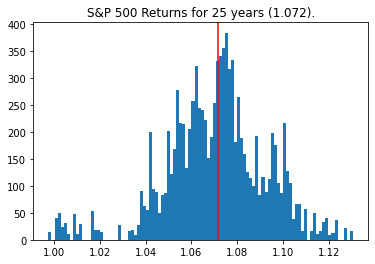

1.0717583922849647


In [16]:
num_years = 25 #@param {type:"slider", min:1, max:60, step:1.0}
start_points=[random.randint(0,(92-num_years)*12) for i in range(NUM_SAMPLES)]
yearly_returns = [calculate_returns(start_points[i],num_years) for i in range(len(start_points))]
ref_returns=np.median(yearly_returns)
pretty_plot_fn(yearly_returns, ref_returns, "S&P 500 Returns for %d years (%1.3f)."%(num_years,ref_returns))
print("%1.4f"%ref_returns)

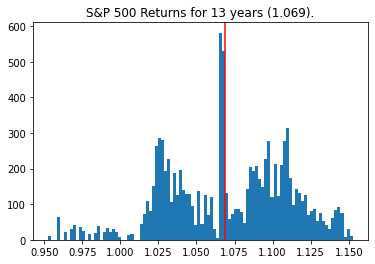

1.0690


In [18]:
num_years = 16 #@param {type:"slider", min:1, max:60, step:1.0}
flexible_years = 3 #@param {type:"slider", min:0, max:15, step:1.0}
# min_acceptable_return is the avg. return that you would be comfortable 
# retiring with, a value of 1.03 means that your investment kept pace with 
# inflation (avg inflation assumed to be 1.03), 1.1 would mean that you would 
# like an average return of 10% per year (values above 1.07 may be unrealistic).
min_acceptable_return = 1.065 #@param {type:"slider", min:1.03, max:1.1, step:0.05}
start_points=[random.randint(0,(92-(num_years+flexible_years))*12) for i in range(NUM_SAMPLES)]
yearly_returns = [flexible_end_date(start_points[i],num_years,flexible_years, min_acceptable_return) for i in range(len(start_points))]
ref_returns=np.median(yearly_returns)
pretty_plot_fn(yearly_returns, ref_returns, "S&P 500 Returns for %d years (%1.3f)."%(num_years,ref_returns))
print("%1.4f"%ref_returns)

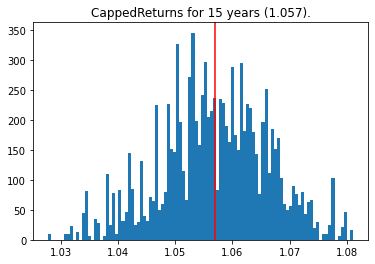

1.0570


In [19]:
num_years = 15 #@param {type:"slider", min:1, max:60, step:1.0}
start_points=[random.randint(0,(92-num_years)*12) for i in range(NUM_SAMPLES)]
yearly_returns = [capped_gains_strategy(start_points[i],num_years) for i in range(len(start_points))]
ref_returns=np.median(yearly_returns)
pretty_plot_fn(yearly_returns, ref_returns, "CappedReturns for %d years (%1.3f)."%(num_years,ref_returns))
print("%1.4f"%ref_returns)

## Systematic monthly investments

These simulations simulate a typical method of saving. One would start with 
an initial investment amount ("intial_amount"), and would then invest some more
amount on a monthly basis ("monthly_amount").

These simulations also account for inflations during the months question, and 
thus try to paint the most accurate picture available. The final value is presented in current year dollar amounts to make it easier to visualize.


In [0]:
# Number of years one has before retirement.
num_years = 20 #@param {type:"slider", min:1, max:60, step:1.0}
# The amount of money that one has at present that you would like to invest.
initial_amount=100 #@param {type:"slider", min:10, max:200, step:1.0}
# If the amount of money is large it would be advisable to split the intial 
# amount of money over "initial_rampup_months" number of months. 
initial_rampup_months=6 #@param {type:"slider", min:1, max:60, step:1.0}
# Amount of money that one would like to invest every month.
monthly_amount=4 #@param {type:"slider", min:1, max:100, step:1.0}

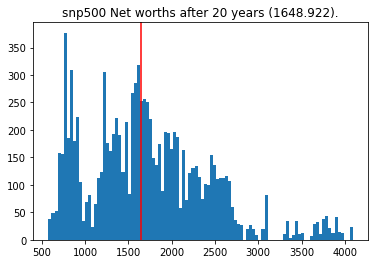

Median final Networth = $1648.9223


In [25]:
# Invest in S&P 500
investment_type = "snp500"  #@param ['snp500', 'savings_account', 'bonds', 'capped_snp500']
start_points=[random.randint(1,(92-num_years)*12) for i in range(NUM_SAMPLES)]
final_networths = [weighted_return(initial_rampup_months, initial_amount, (num_years*12), monthly_amount, start_points[i],investment_type) for i in range(len(start_points))]
ref_nw=np.median(final_networths)
pretty_plot_fn(final_networths, ref_nw, "%s Net worths after %d years (%1.3f)."%(investment_type, num_years,ref_nw))
print("Median final Networth = $%4.4f"%ref_nw)

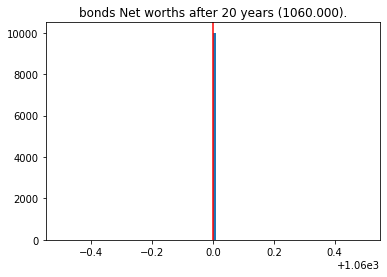

Median final Networth = $1060.0000


In [26]:
investment_type = "bonds"  #@param ['snp500', 'savings_account', 'bonds', 'capped_snp500']
start_points=[random.randint(1,(92-num_years)*12) for i in range(NUM_SAMPLES)]
final_networths = [weighted_return(initial_rampup_months, initial_amount, (num_years*12), monthly_amount, start_points[i],investment_type) for i in range(len(start_points))]
ref_nw=np.median(final_networths)
pretty_plot_fn(final_networths, ref_nw, "%s Net worths after %d years (%1.3f)."%(investment_type, num_years,ref_nw))
print("Median final Networth = $%4.4f"%ref_nw)

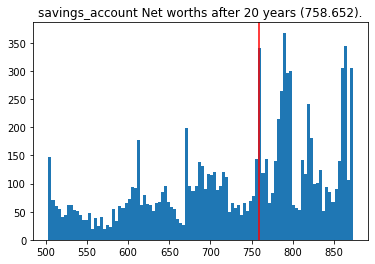

Median final Networth = $758.6522


In [27]:
investment_type = "savings_account"  #@param ['snp500', 'savings_account', 'bonds', 'capped_snp500']
start_points=[random.randint(1,(92-num_years)*12) for i in range(NUM_SAMPLES)]
final_networths = [weighted_return(initial_rampup_months, initial_amount, (num_years*12), monthly_amount, start_points[i],investment_type) for i in range(len(start_points))]
ref_nw=np.median(final_networths)
pretty_plot_fn(final_networths, ref_nw, "%s Net worths after %d years (%1.3f)."%(investment_type, num_years,ref_nw))
print("Median final Networth = $%4.4f"%ref_nw)

## COVID-19 ish simulations

Given the current financial situation, the current markets are a-typical. Thus the simlations below show returns around past recessions.

In [29]:
#  Bear Markets finder (more than 20% drop from the previous high)
#  https://www.investopedia.com/terms/b/bearmarket.asp
#  Top 11 Bear market dates = http://www.nbcnews.com/id/37740147/ns/business-stocks_and_economy/t/historic-bear-markets/#.XoCWDzdKh24

bear_market_dates=['1929-09-01', '1946-05-01', '1961-12-01', '1968-11-01', '1973-01-01', '1980-11-01', '1987-08-01', '2000-03-01', '2007-10-01']
bear_market_months=[fin_index.get_loc(bear_date) for bear_date in bear_market_dates]
print(bear_market_months)

[20, 220, 407, 490, 540, 634, 715, 866, 957]


In [34]:
num_years = 20 #@param {type:"slider", min:1, max:60, step:1.0}
initial_rampup_months=6 #@param {type:"slider", min:1, max:60, step:1.0}
initial_amount=100 #@param {type:"slider", min:10, max:200, step:1.0}
monthly_invest=4 #@param {type:"slider", min:1, max:100, step:1.0}
month_offset=-1
start_points=[month+month_offset for month in bear_market_months[:8]]
# print(start_points)

#  investment_type: 0=s&p500, 1=capped_s&p500, 2=bank, 3=bonds(tbd)
for toi in ['bonds', 'snp500', 'savings_account', 'capped_snp500']:
  tinvest = monthly_invest
  if toi == 1:
    tinvest-=1
  final_networths = [weighted_return(initial_rampup_months, initial_amount, (num_years*12), tinvest, start_points[i], toi) for i in range(len(start_points))]
  # final_networths = np.sort(final_networths)
  avg_nw=np.average(final_networths)
  med_nw=np.median(final_networths)
  print('Type of investment : %s \t Median Networths : %f'%(toi, med_nw))
  print(final_networths)
  print()


Type of investment : bonds 	 Median Networths : 1060.000000
[1060.0, 1060.0, 1060.0, 1060.0, 1060.0, 1060.0, 1060.0, 1060.0]

Type of investment : snp500 	 Median Networths : 1801.054272
[816.5663844902134, 2505.1719497440636, 667.5065392020023, 1260.9234851984277, 1670.8253135172877, 3687.5137888154172, 2003.5642632748668, 1931.2832309902376]

Type of investment : savings_account 	 Median Networths : 730.257284
[696.1735462599163, 869.8343344777593, 506.7790551959012, 599.3995860136782, 635.9306876121261, 764.341021261995, 792.0727576830466, 862.5957613877551]

Type of investment : capped_snp500 	 Median Networths : 1873.484482
[1786.0115717087594, 1931.146211157738, 1685.5720432858795, 1757.0481212765123, 1815.8227519742852, 2002.1863753151677, 1949.9080441941733, 1960.2129454778546]



In [8]:
findata.loc[-5:]

,Date,Close,Adj Close,Inflation,Scale,Scale_InfAdj
0,1928-01-01,17.570000,17.570000,-1.14,NaN,NaN
1,1928-02-01,17.260000,17.260000,-1.72,0.982356,0.983790
2,1928-03-01,19.280001,19.280001,-1.16,1.117034,1.118000
3,1928-04-01,19.750000,19.750000,-1.16,1.024378,1.025344
4,1928-05-01,20.000000,20.000000,-1.15,1.012658,1.013617
...,...,...,...,...,...,...
1101,2019-10-01,3037.560059,3037.560059,1.76,1.020432,1.018965
1102,2019-11-01,3140.979980,3140.979980,2.05,1.034047,1.032339
1103,2019-12-01,3230.780029,3230.780029,2.29,1.028590,1.026681
1104,2020-01-01,3225.520020,3225.520020,2.49,0.998372,0.996297
